# MCMC Model - SPT Sample

Allen Pinjic - Created on May 31st, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
import numpy as np

In [2]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))

In [3]:
import pandas as pd

#Data visualization package for Python
import arviz as az

import matplotlib.pyplot as plt
import pylab as plt

#Bayesian package for Python
import pymc3 as pm

#to simplify math formula management
import aesara

#To help create the corner plot using pymc3
import exoplanet
exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

import matplotlib.font_manager


import scipy.stats
import scipy.optimize
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


exoplanet.__version__ = '0.5.2'


In [4]:
df = data.to_pandas()

h = 0.7
df['log_M500'] = np.log(df.M500*1e14*h)
df['log_LAMBDA_CHISQ'] = np.log(df.LAMBDA_CHISQ)

/data0/sw/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# Calculating the log of the mean mass error
h=0.7
m500 = df.M500.to_numpy()*1e14*h
log_m500 = np.log(m500)

lerr = df.M500_LERR.to_numpy()*1e14*h
uerr = df.M500_UERR.to_numpy()*1e14*h

m500_err = (lerr+uerr)/2 # mean mass error
log_m500_err = m500_err/m500

# Eliminating NaN values from the log_m500_err data set
nnan = ~np.isnan(log_m500_err)
nnan2 = ~np.isnan(log_m500)

<ipython-input-5-ce5e59d41f0a>:4: RuntimeWarning: divide by zero encountered in log
  log_m500 = np.log(m500)
<ipython-input-5-ce5e59d41f0a>:10: RuntimeWarning: invalid value encountered in true_divide
  log_m500_err = m500_err/m500


In [6]:
# Calculating the log of the richness error

lbd = df.LAMBDA_CHISQ.to_numpy()
lbd_err = df.LAMBDA_CHISQ_E.to_numpy()

log_lbd = df.log_LAMBDA_CHISQ
log_lbd_err = lbd_err/lbd

# Eliminating NaN values from the log_lbd_err data set
nnan3 = ~np.isnan(log_lbd_err)
nnan4 = ~np.isnan(log_lbd)

nnan_all = nnan & nnan2 & nnan3 & nnan4

<ipython-input-6-41f86079a195>:7: RuntimeWarning: invalid value encountered in true_divide
  log_lbd_err = lbd_err/lbd


In [7]:
df0 = df
z = df0.REDSHIFT.to_numpy()
lbd = df0.LAMBDA_CHISQ.to_numpy()
zcut = (z > 0.1) & (z < 0.65)
lcut = lbd > 20
final_cut = zcut & lcut

In [8]:
df = df0.loc[final_cut].copy()

In [9]:
df

,SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,REDSHIFT_SOURCE,...,LAMBDA_CHISQ,LAMBDA_CHISQ_E,RADIO_CONTAM,STRONG_LENS,IMAGE_SOURCE,SPECZ_REF,STRONG_LENS_REF,PHOTOMETRIC_ZREF,log_M500,log_LAMBDA_CHISQ
1,SPT-CLJ0005-3751,1.438318,-37.854369,ra1hdec-35,6.336327,0.75,0.482958,0.007242,0,4.0,...,86.408386,4.735215,0.0,1.0,3.0,,,,33.569427,4.459085
2,SPT-CLJ0005-3443,1.487651,-34.719271,ra1hdec-35,5.514429,2.00,0.114000,0.000000,1,9.0,...,105.385574,4.646943,0.0,0.0,8.0,1989ApJS...70....1A,,,33.551929,4.657626
7,SPT-CLJ0020-2543,5.173062,-25.727583,ra1hdec-25,7.141808,1.50,0.141000,0.000000,1,9.0,...,101.159950,18.001257,0.0,0.0,8.0,1999ApJS..125...35S,,,33.831551,4.616703
10,SPT-CLJ0042-2831,10.526915,-28.522130,ra1hdec-25,8.122652,1.75,0.108600,0.000000,1,9.0,...,70.527962,2.828000,0.0,0.0,8.0,2002MNRAS.329...87D,,,33.928371,4.256009
11,SPT-CLJ0042-3809,10.613344,-38.151329,ra1hdec-35,6.616126,1.25,0.219660,0.000000,1,9.0,...,74.723076,2.981047,0.0,0.0,8.0,1996ApJ...470..172S,,,33.672108,4.313789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,SPT-CLJ0552-4008,88.123056,-40.136343,ra5hdec-35,4.359108,2.00,0.362500,0.009275,0,4.0,...,65.890450,4.650317,0.0,0.0,3.0,,,,33.253738,4.187994
429,SPT-CLJ0554-3149,88.528647,-31.830573,ra5hdec-35,4.620441,0.25,0.218471,0.005045,0,4.0,...,21.193373,2.535579,0.0,0.0,3.0,,,,33.334869,3.053689
430,SPT-CLJ0556-2502,89.156331,-25.042366,ra5hdec-25,4.130208,0.25,0.624432,0.013504,0,4.0,...,20.384859,2.782436,0.0,0.0,3.0,,,,33.170399,3.014792
431,SPT-CLJ0557-2626,89.371706,-26.437366,ra5hdec-25,4.008900,0.75,0.598462,0.008865,0,4.0,...,45.250465,3.503051,0.0,0.0,3.0,,,,33.166267,3.812213


In [10]:
# The function of the first two lines is to make sure that regardless
# of where this code is used, the readout will always be the same
seed = 0
rng = np.random.default_rng(seed)

# Configures the apperance of any generated plot 
## (similar to seaborn)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [11]:
import statsmodels.api as sm

# Like in the file Experimenting_With_Models, using x as df['log_LAMBDA_CHISQ']
# and y as df['log_M500'], there is an error since the array sizes are not the same

# Using X = df['log_LAMBDA_CHISQ'] and Y = df['log_M500']
# or X = logRichnessArray = df['log_LAMBDA_CHISQ'].to_numpy() and Y = logOfMassArray = df['log_M500'].to_numpy()
# or X = log_lbd[nnan_all] and Y = log_m500[nnan_all]
# all have array sizes that do not match the given setting below.
# However, while changing the size to the one of the given array solves the problem,
# they all give different estimates for the slope and y-intercept below


X = log_m500[nnan_all]
X = sm.add_constant(X)
Y = log_lbd[nnan_all]

reg = sm.OLS(Y, X)
result = reg.fit()

print(result.summary())

Y_pred = result.predict()
Y_pred.shape = (298,1)

print(X.shape)
print(Y.shape)

                            OLS Regression Results                            
Dep. Variable:       log_LAMBDA_CHISQ   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     145.7
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.53e-27
Time:                        14:59:56   Log-Likelihood:                -173.62
No. Observations:                 298   AIC:                             351.2
Df Residuals:                     296   BIC:                             358.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.6990      3.466    -10.878      0.0

### Results from Various Array Types

##### When X = df['log_LAMBDA_CHISQ'] and Y = df['log_M500'], m = 13.9807 & b = 0.2943


##### When X = logRichnessArray = df['log_LAMBDA_CHISQ'].to_numpy() and Y = logOfMassArray = df['log_M500'].to_numpy(),
##### m = 13.9807 & b = 0.2943


##### When X = log_lbd[nnan_all] and Y = log_m500[nnan_all], m = 14.0202 & b = 0.2631

In [12]:
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [13]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
    # Define priors
    # Find out info regarding sigma parameters (beta?)
    
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    A_lambda = pm.Normal("A_lambda", mu=76.9, sigma=(8.2*3))
    B_lambda = pm.Normal("B_lambda", mu=1.020, sigma=(0.080*3))
    C_lambda = pm.Normal("C_lambda", mu=0.29, sigma=(0.27*3))

    # Define likelihood
    equation = (np.log(A_lambda) + (B_lambda)*(np.log((m500[nnan_all])/(3e14))) + (C_lambda)*(np.log((E(z[nnan_all]))/(E(0.6)))))
    likelihood = pm.Normal("y",mu=equation, sigma=sigma, observed=Y)
    

    # Inference
    trace = pm.sample(10000, cores=16, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [C_lambda, B_lambda, A_lambda, sigma]


Sampling 16 chains for 1_000 tune and 10_000 draw iterations (16_000 + 160_000 draws total) took 45 seconds.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


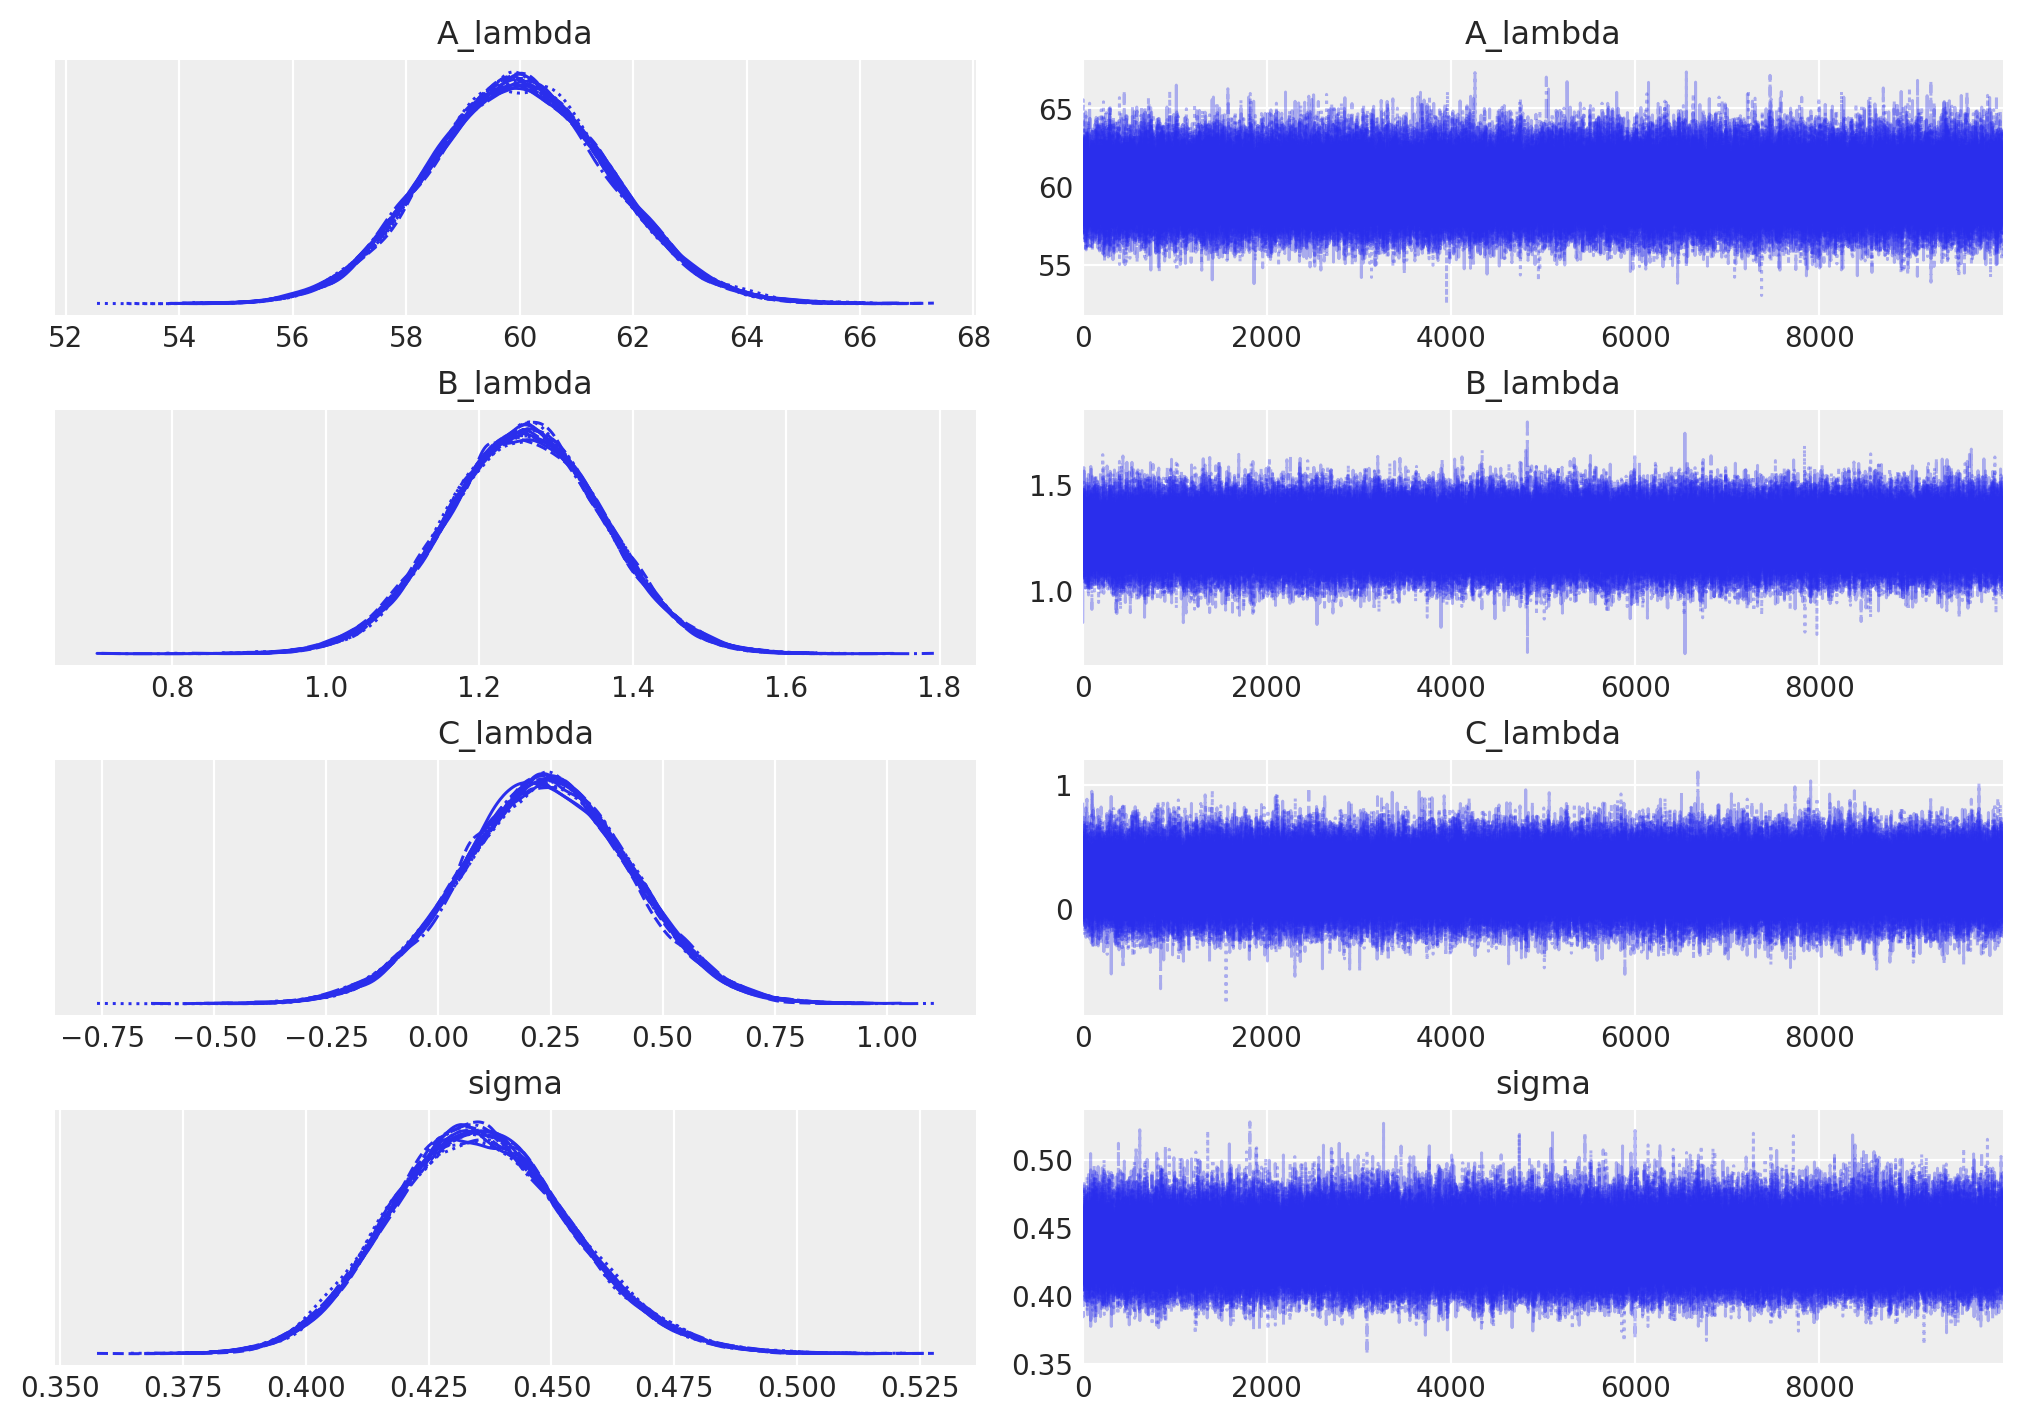

In [14]:
az.plot_trace(trace, figsize=(10, 7));

In [15]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A_lambda,60.000,1.574,57.039,62.918,0.003,0.002,217289.0,129260.0,1.0
B_lambda,1.259,0.102,1.067,1.449,0.000,0.000,192250.0,128990.0,1.0
C_lambda,0.241,0.186,-0.108,0.590,0.000,0.000,179730.0,129333.0,1.0
sigma,0.436,0.018,0.402,0.470,0.000,0.000,216358.0,120337.0,1.0


In [16]:
trace.values

<bound method InferenceData.values of Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data>

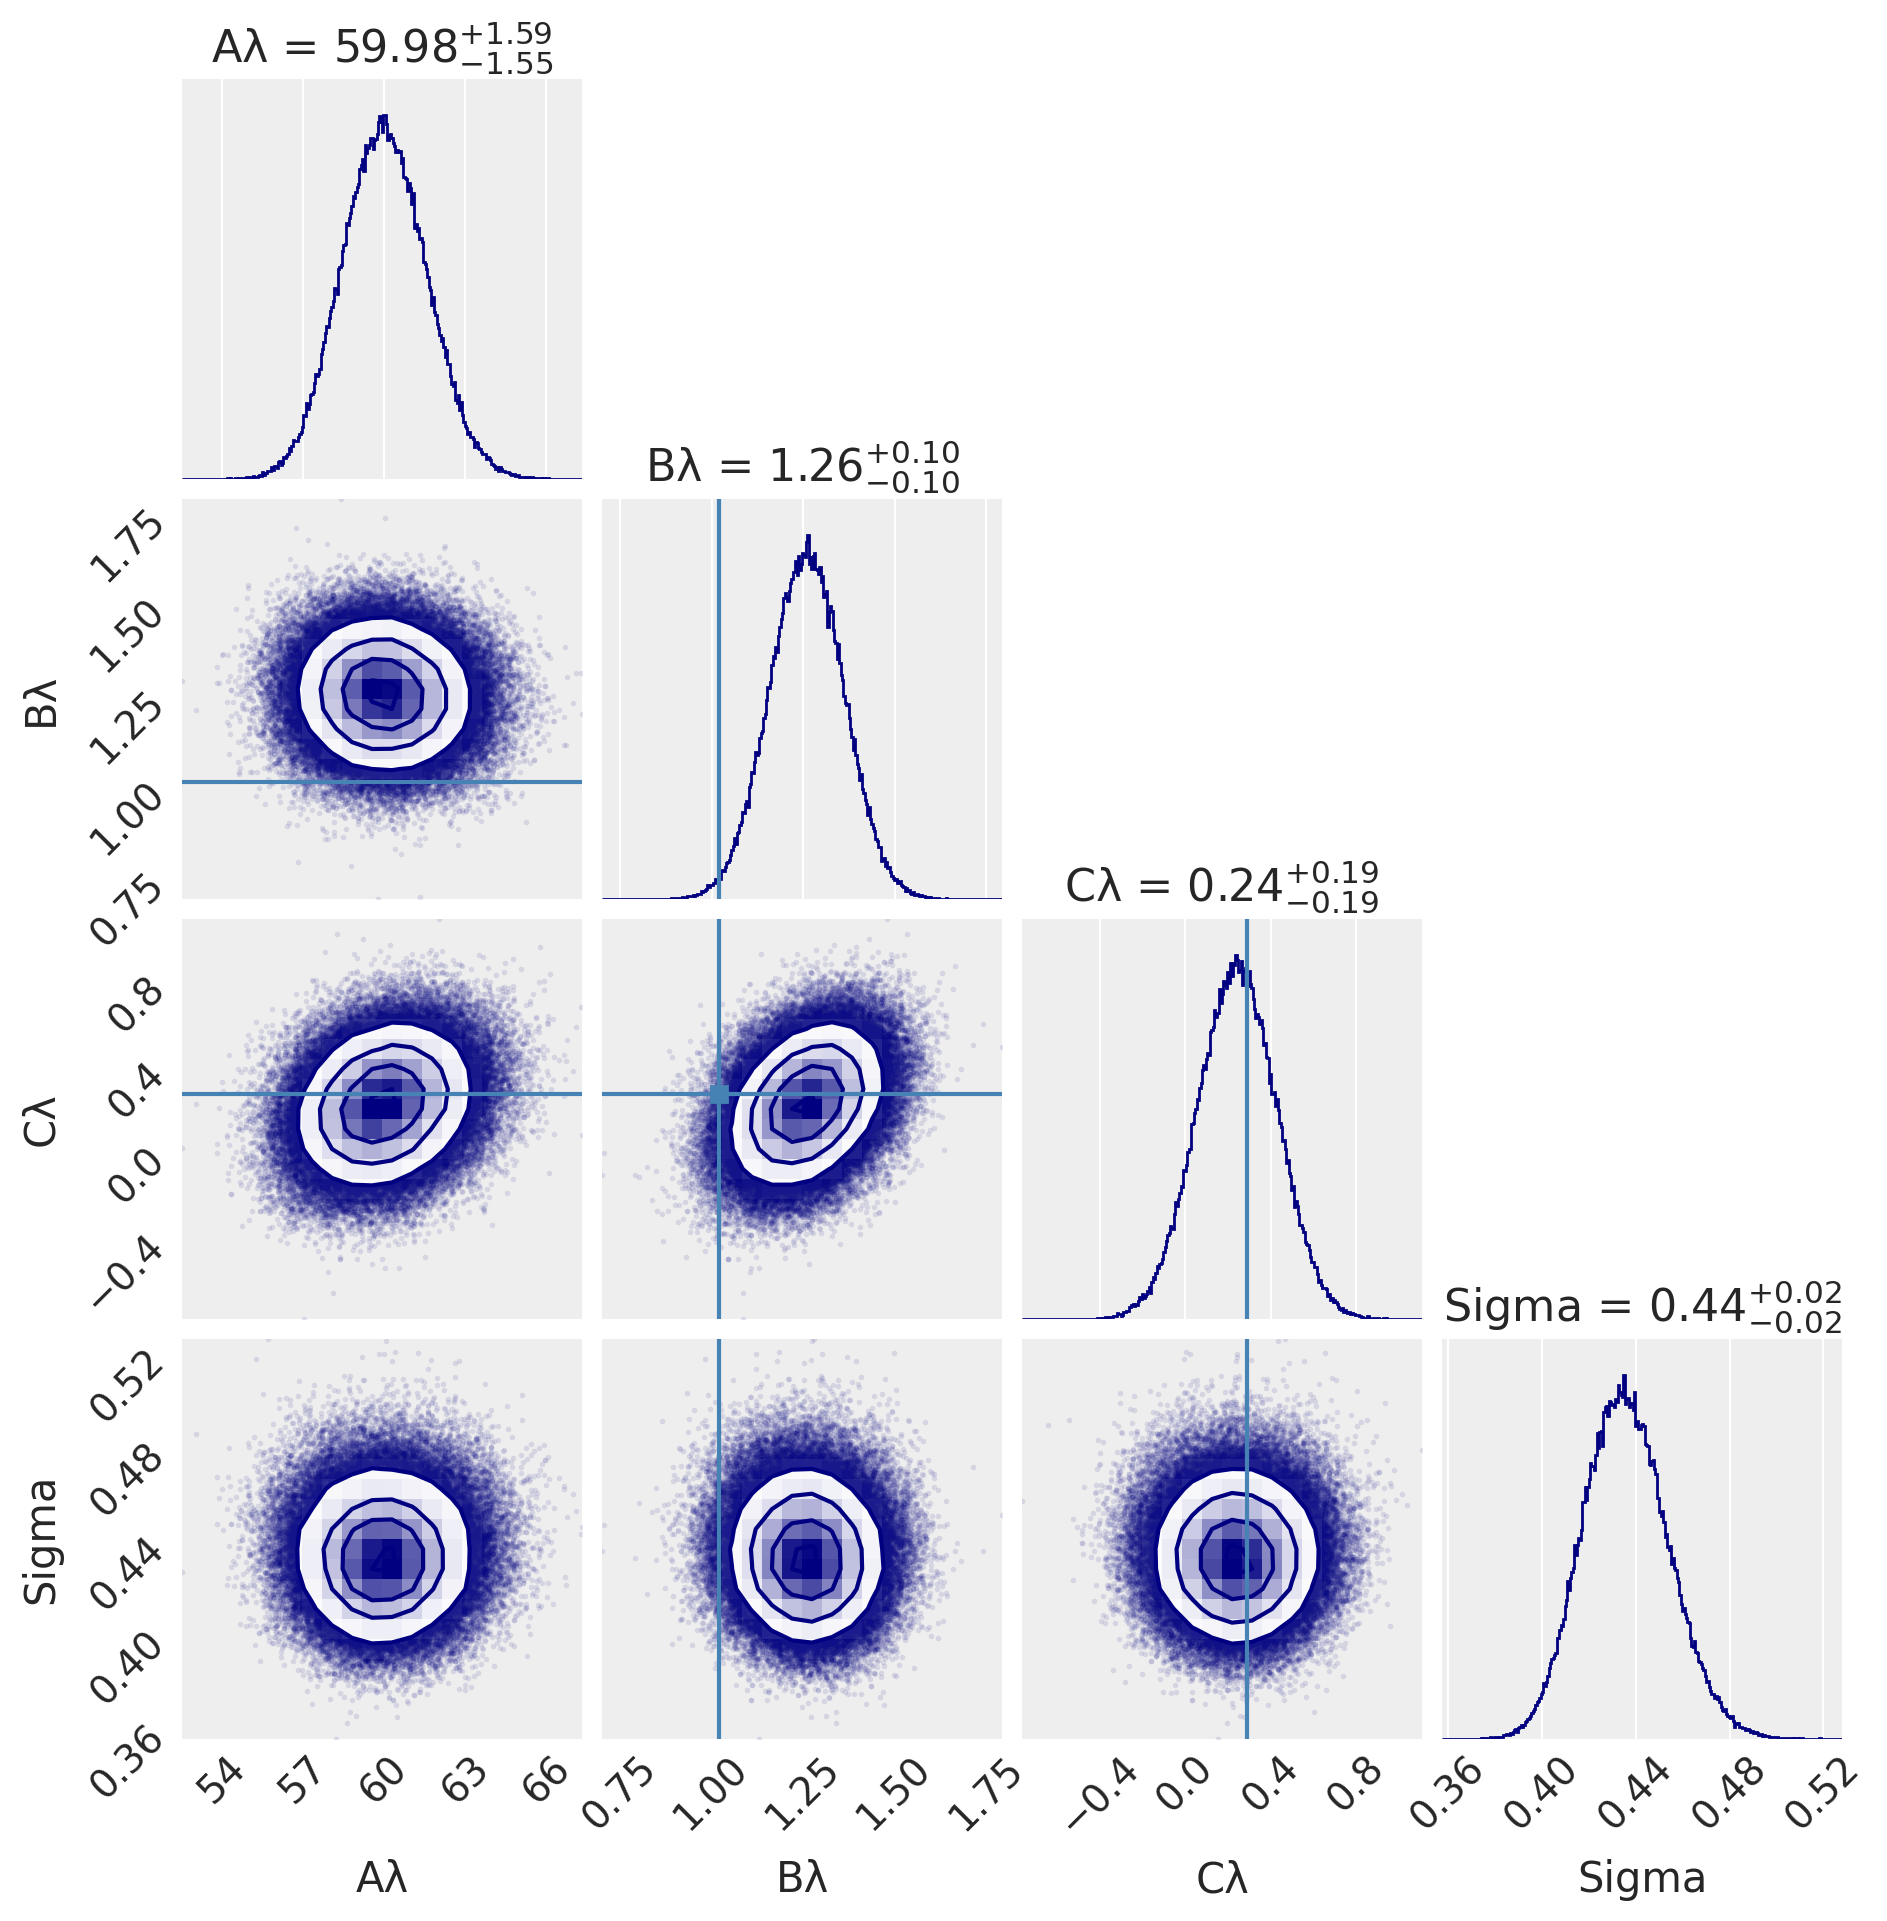

In [27]:
import corner

# The truth values below represent the mean value of each prior 
# with which we could compare the model that is generated
A_lambda_true = 76.9
B_lambda_true = 1.020
C_lambda_true = 0.29
sigma_true = 0.23
# truths=[m_true, b_true, np.log(f_true)] ( in corner.corner() )

#----------------------------------------------------------------

# ALTERNATE VERSIONS
#_ = corner.corner(
#    trace,
#    truths=dict(m=m_true, b=b_true, logs=f_true),
#)

#fig = corner.corner(
#    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
#);


fig = corner.corner(
    trace, labels=[r"Aλ", r"Bλ", r"Cλ", r"Sigma"],  show_titles = True, divergences=True, 
    color='navy', hist_bin_factor = 15, truths=[A_lambda_true, B_lambda_true, C_lambda_true, sigma_true]);
